# Decaying network (parrot neurons)


- a network of 100 excitatory cells without any recurrent connections and inhibitions

## define fileName, saving path and libraries

In [1]:
# fileName

fileName = 'eg_decaying-network' 

In [2]:
# spinnaker and brian

In [3]:
try:
    import pyNN.spiNNaker as sim
except ModuleNotFoundError:
    import pyNN.brian2 as sim
    
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
import datetime
import json
import warnings
warnings.filterwarnings('ignore')
import python_utils as pu
%matplotlib inline

savePath = f'../outputs/' # remember to create the folder if not already present (mkdir ./notebooks/outputs)
dt_string = datetime.datetime.today().isoformat() # ISO8601 ! :-)
tag = dt_string 
saveName = f'{savePath}{fileName}-{tag}'
print(saveName)
PARS={}


../outputs/eg_decaying-network-2025-06-04T20:10:25.864988


## simulations settings

In [4]:
sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 250 #ms

2025-06-04 20:10:25 INFO: Read cfg files: /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/bbpnrsoa/.spynnaker.cfg
2025-06-04 20:10:25 INFO: Will search these locations for binaries: /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/common_model_binaries : /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/model_binaries
2025-06-04 20:10:25 WARNING: /home/bbpnrsoa/CNT-2025/notebooks/intro/reports has 13 old reports that have not been closed
2025-06-04 20:10:25 INFO: Setting time scale factor to 10.
2025-06-04 20:10:25 INFO: Setting machine time step to 1000 micro-seconds.


['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']


## network design

In [5]:
pops = {}
n_cells = {}
neuron_Model = {}
neuron_ModelPars = {}
initial_Values = {}

for popName in ['network']:
    n_cells[popName] = 100
    neuron_Model[popName] = sim.IF_cond_exp
    neuron_ModelPars[popName] = sim.IF_cond_exp.default_parameters # or standard_pars or testing_pars
    initial_Values[popName] = sim.IF_cond_exp.default_initial_values
    pops[popName] = sim.Population(n_cells[popName], 
                                   neuron_Model[popName],
                                   neuron_ModelPars[popName],
                                   structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                                   label = popName)

    pops[popName].record(['spikes','v','gsyn_exc','gsyn_inh'])   
 


## input design

array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59])

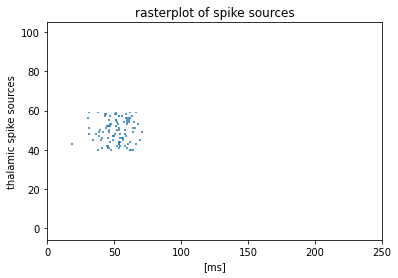

In [6]:
# make the thalamic input sources

popName = 'Thalamus'  

n_cells[popName] = n_cells['network']
spike_times = [[]]*n_cells[popName] #list of spike lists, where one spike list is related to one spike source
#random_sources_idx = [np.random.randint(n_cells[popName]*0.40, n_cells[popName]*0.60) for i in range(n_cells[popName])]
random_sources_idx = np.arange(int(n_cells[popName]*0.40), int(n_cells[popName]*0.60))

for idx, sources in enumerate(random_sources_idx):
    spike_times[sources] = np.sort([abs(np.random.normal(loc=50, scale=10)) for n in range(5)])

neuron_Model[popName] = sim.SpikeSourceArray(spike_times=spike_times)


pops[popName] = sim.Population(n_cells[popName], 
                               neuron_Model[popName],
                               structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                               label = popName)

proj = {}
proj['Thalamus', 'network'] = sim.Projection(pops['Thalamus'], 
                                         pops['network'],
                                         connector = sim.OneToOneConnector(),
                                         synapse_type = sim.StaticSynapse(weight=0.08, delay=1),
                                         space = space.Space(axes = 'x'),
                                         receptor_type = 'excitatory',
                                         label = 'thalamus-network connections')

fig, axes = plt.subplots(1,1)
axes_list = fig.axes
axes_list[0].eventplot(spike_times)
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('thalamic spike sources')
axes_list[0].set_title('rasterplot of spike sources')
axes_list[0].set_xlim(0, simtime)

random_sources_idx

## run the simulations

In [7]:
tic = time.time()
sim.run(simtime)
toc = time.time() - tic

2025-06-04 20:10:26 INFO: Starting execution process
2025-06-04 20:10:26 INFO: Simulating for 250 1.0ms timesteps using a hardware timestep of 10000us
Adding Splitter selectors where appropriate
|0%                          50%                         100%|
2025-06-04 20:10:26 INFO: Time 0:00:00.013524 taken by SpynnakerSplitterSelector
Adding delay extensions as required
|0%                          50%                         100%|
2025-06-04 20:10:26 INFO: Time 0:00:00.011973 taken by DelaySupportAdder
2025-06-04 20:10:29 INFO: Time 0:00:03.437702 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2025-06-04 20:10:42 INFO: Time 0:00:13.179816 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2025-06-

## save and recover stateVars

In [8]:
stateVars = {}
for pop in pops.keys():
    for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
        pops[pop].write_data(f'{saveName}-{recording}.pkl')
        stateVars[pop]=pops[pop].get_data()

stateVars.keys()
results = pu.recover_results(stateVars)
results.keys()

Getting spikes for network
|0%                          50%                         100%|
Getting v for network
|0%                          50%                         100%|
Getting gsyn_exc for network
|0%                          50%                         100%|
Getting gsyn_inh for network
|0%                          50%                         100%|
Getting spikes for network
|0%                          50%                         100%|
Getting v for network
|0%                          50%                         100%|
Getting gsyn_exc for network
|0%                          50%                         100%|
Getting gsyn_inh for network
|0%                          50%                         100%|
Getting spikes for network
|0%                          50%                         100%|
Getting v for network
|0%                          50%                         100%|
Getting gsyn_exc for network
|0%                          50%                         100%|
Getting gsyn_in

network
v
gsyn_exc
gsyn_inh
Thalamus


dict_keys([('network', 'v'), ('network', 'gsyn_exc'), ('network', 'gsyn_inh'), ('network', 'spikes'), ('Thalamus', 'spikes')])

## postprocessing

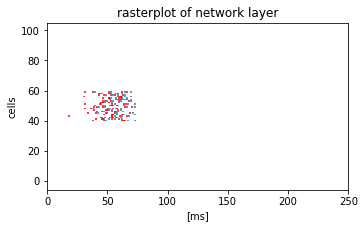

In [9]:
# check the spikes

fig, axes = plt.subplots(1, 1)
fig.tight_layout(pad=5)
axes_list = fig.axes

for idx, value in enumerate(['network']):
    axes_list[idx].eventplot(results[value, 'spikes'], label='cell')
    axes_list[idx].eventplot(spike_times, color='r', label='thalamic input')
    axes_list[idx].set_title('rasterplot of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('[ms]')
    axes_list[idx].set_ylabel('cells')
    axes_list[idx].set_xlim(0, simtime)


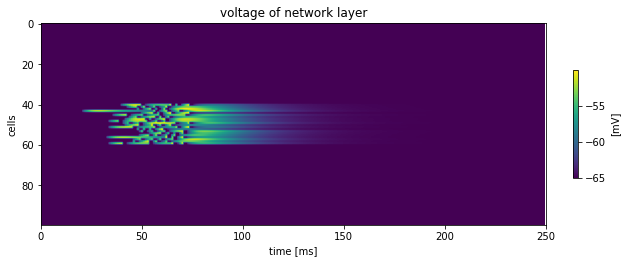

In [10]:
# check the voltage

fig, axes = plt.subplots(1, 1, figsize=(9,9))
fig.tight_layout(pad=4)

axes_list = fig.axes

for idx, value in enumerate(['network']):
    im = axes_list[idx].imshow(results[value, 'v'].T)
    axes_list[idx].set_title('voltage of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('time [ms]')
    axes_list[idx].set_ylabel('cells')
    axes_list[idx].set_xlim(0, simtime)
    fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[mV]')

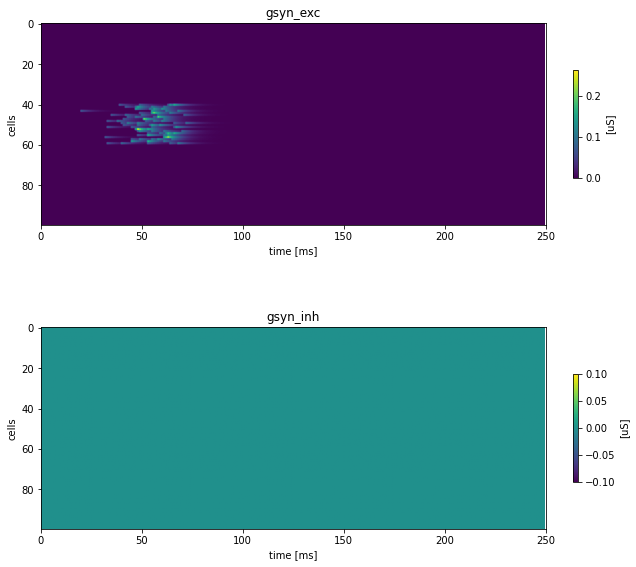

In [11]:
# check the conductances

# check the voltage

fig, axes = plt.subplots(2, 1, figsize=(9,9))
fig.tight_layout(pad=4)

axes_list = fig.axes

for idx, value in enumerate(['network']):
    for idx, gsyn in enumerate(['gsyn_exc', 'gsyn_inh']):
        im = axes_list[idx].imshow(results['network', gsyn].T)
        axes_list[idx].set_title(str(gsyn))
        axes_list[idx].set_xlabel('time [ms]')
        axes_list[idx].set_ylabel('cells')
        axes_list[idx].set_xlim(0, simtime)
        fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[uS]')


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 10.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 10 - 500 Hz                       
                                 Frequency Resolution is 10.00 Hz                                 
                                                                        

<Figure size 720x360 with 0 Axes>

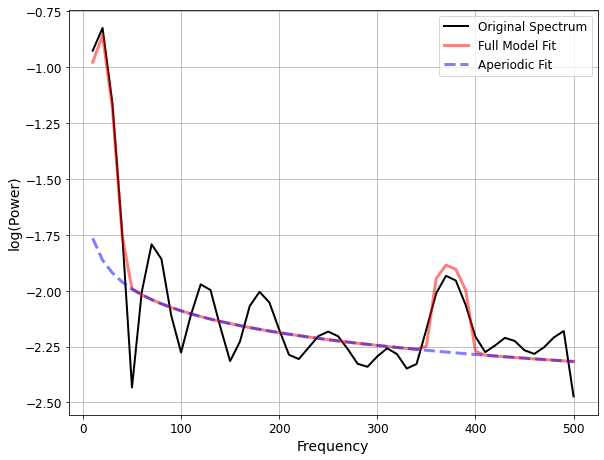

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from fooof import FOOOF

fs = 1 * 1e3  # frequenza di campionamento in Hz
nperseg = 1e3*0.5  # lunghezza del segmento per Welch

plt.figure(figsize=(10, 5))
for label, color in zip(['network'], ['r']):
    sig = np.asarray(results[label, 'v']).T  # shape (300, 1000)
    f, psd = welch(sig, fs=fs, axis=0, nperseg=nperseg)
    psd_mean = np.mean(psd, axis=1)
    psd_sem = np.std(psd, axis=1) / np.sqrt(psd.shape[1])  # SEM
    #plt.plot(f, psd_mean, label=f'{label.upper()} - Media PSD', c=color)
    #plt.fill_between(f, psd_mean - psd_sem, psd_mean + psd_sem, color=color, alpha=0.3, label=f'{label.upper()} ±1 SEM')
    # --- Fit FOOOF ---
    fm = FOOOF(peak_width_limits=[1, 12], max_n_peaks=6, aperiodic_mode='fixed')
    fm.report(f, psd_mean)   
    
    



## end simulation

In [ ]:
sim.end()

# remember that if you end the simulation, 
# than some PyNN routines are not working anymore, 
# so close only at the very end of your analysis